In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Tue Jan 16 01:30:44 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   49C    P5    75W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 33%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.trainable_sigma_spiral_tlse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
def generate_spiral_data_torch(points_per_class, num_classes):
    """
    This function generates spiral data with the specified number of points per class
    and the specified number of classes using PyTorch.
    """
    X = []
    y = []
    num_points = points_per_class * num_classes
    radius = torch.linspace(0.0, 1, points_per_class)
    
    for i in range(num_classes):
        theta = torch.linspace(i * 4 * np.pi / num_classes, (i + 1) * 4 * np.pi / num_classes, points_per_class) + torch.randn(points_per_class) * 0.2
        x1 = radius * torch.sin(theta)
        x2 = radius * torch.cos(theta)
        X.append(torch.stack((x1, x2), dim=1))
        y += [i] * points_per_class

    X = torch.cat(X)
    y = torch.tensor(y)
    return X, y

def get_kl(M, N, k, post_sigma, elem_sigma, prior_sigma=1.0):
    # z : (M, z)
    # mu : (N, z)
    
    z = generate_spiral_data_torch(M//5, 5)[0].cuda() * prior_sigma
    mu = generate_spiral_data_torch(N//5, 5)[0].cuda() * post_sigma
            
    # (M, N) = sum((M, 1, z) - (1, N, z), dim=2)
    distance = torch.norm(z.unsqueeze(1) - mu.unsqueeze(0), dim=2) ** 2
    alpha = -1/(2*elem_sigma**2)
    loss = -torch.mean(torch.logsumexp(alpha*distance, dim=1), dim=0)
    loss = loss + 0.5*k*(2*np.log(elem_sigma)-np.log(np.e)) + np.log(N)
    
    return loss.item()

from tqdm import tqdm

M = 1024
N = 256
k = 2
post_sigma = 1
elem_log_sigmas = np.arange(-10, 10, 0.01)

losses_list = []
for _ in tqdm(range(10)):
    losses = np.array([get_kl(M, N, k, post_sigma, np.exp(elem_log_sigma)) for elem_log_sigma in elem_log_sigmas])
    losses_list.append(losses)
    
losses = np.median(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

losses = np.mean(np.array(losses_list), axis=0)
optimum_sigma = np.exp(elem_log_sigmas[np.argmin(losses)])
print(optimum_sigma, np.log(optimum_sigma))

100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.69s/it]

0.05028743672358436 -2.9900000000001494
0.05960594270893023 -2.820000000000153


In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.init_log_sigma = -3
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 3.814697265625e-06
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.14-18/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 370964
-rw-rw-r-- 1 scpark scpark     64772  1월 16 01:30 events.out.tfevents.1705335934.GPUSVR01
-rw-rw-r-- 1 scpark scpark 379799247  1월 16 01:27 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

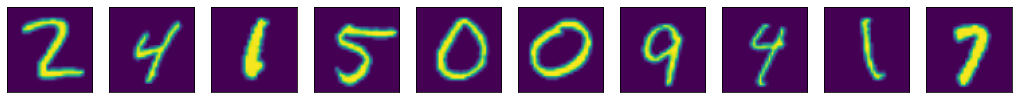

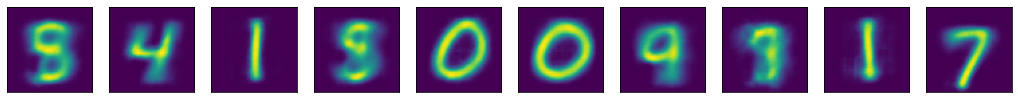

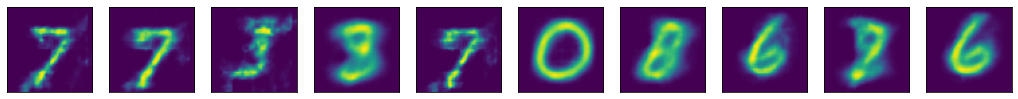

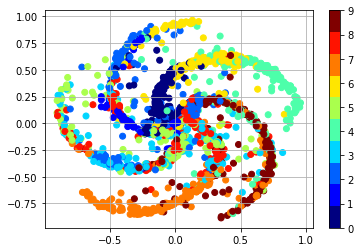

14001
lse_loss -1.9834356307983398
recon_loss 0.1618853062391281
14002
lse_loss -1.953237533569336
recon_loss 0.15572607517242432
14003
lse_loss -1.9227313995361328
recon_loss 0.16070561110973358
14004
lse_loss -1.9312949180603027
recon_loss 0.15965816378593445
14005
lse_loss -1.9756336212158203
recon_loss 0.1498502790927887
14006
lse_loss -1.9646000862121582
recon_loss 0.16451309621334076
14007
lse_loss -1.9887804985046387
recon_loss 0.1596418023109436
14008
lse_loss -1.9845080375671387
recon_loss 0.15666905045509338
14009
lse_loss -1.9973349571228027
recon_loss 0.156732439994812
14010
lse_loss -1.9708657264709473
recon_loss 0.16251423954963684
14011
lse_loss -1.9345216751098633
recon_loss 0.157817542552948
14012
lse_loss -2.009769916534424
recon_loss 0.164186030626297
14013
lse_loss -2.0281262397766113
recon_loss 0.16612005233764648
14014
lse_loss -1.9836912155151367
recon_loss 0.16364111006259918
14015
lse_loss -1.969531536102295
recon_loss 0.15651382505893707
14016
lse_loss -2.0089

lse_loss -1.984781265258789
recon_loss 0.1580057442188263
14128
lse_loss -2.002035140991211
recon_loss 0.1598905771970749
14129
lse_loss -1.9257078170776367
recon_loss 0.15853452682495117
14130
lse_loss -1.9287762641906738
recon_loss 0.15883377194404602
14131
lse_loss -1.9587469100952148
recon_loss 0.1588047593832016
14132
lse_loss -2.0046305656433105
recon_loss 0.16245165467262268
14133
lse_loss -2.013810157775879
recon_loss 0.16745448112487793
14134
lse_loss -1.9772987365722656
recon_loss 0.15652433037757874
14135
lse_loss -1.9609103202819824
recon_loss 0.15412172675132751
14136
lse_loss -1.9786314964294434
recon_loss 0.16067039966583252
14137
lse_loss -1.9876513481140137
recon_loss 0.1563389152288437
14138
lse_loss -2.0005998611450195
recon_loss 0.16395792365074158
14139
lse_loss -1.924837589263916
recon_loss 0.1645774245262146
14140
lse_loss -1.9891939163208008
recon_loss 0.1609567254781723
14141
lse_loss -1.8416376113891602
recon_loss 0.16500002145767212
14142
lse_loss -1.98089027

lse_loss -1.9869379997253418
recon_loss 0.15893439948558807
14255
lse_loss -1.9981498718261719
recon_loss 0.1542549729347229
14256
lse_loss -1.8404169082641602
recon_loss 0.1660001426935196
14257
lse_loss -1.9446697235107422
recon_loss 0.16196951270103455
14258
lse_loss -2.0073599815368652
recon_loss 0.15778522193431854
14259
lse_loss -2.0053343772888184
recon_loss 0.15930485725402832
14260
lse_loss -2.011096954345703
recon_loss 0.16698531806468964
14261
lse_loss -1.8754353523254395
recon_loss 0.1632862538099289
14262
lse_loss -1.9327869415283203
recon_loss 0.16217154264450073
14263
lse_loss -1.9817090034484863
recon_loss 0.16276034712791443
14264
lse_loss -1.9182682037353516
recon_loss 0.1594105064868927
14265
lse_loss -1.9871535301208496
recon_loss 0.1565726101398468
14266
lse_loss -1.991600513458252
recon_loss 0.16281986236572266
14267
lse_loss -1.962815284729004
recon_loss 0.16019847989082336
14268
lse_loss -1.9402589797973633
recon_loss 0.15479236841201782
14269
lse_loss -1.963794

14380
lse_loss -1.9663338661193848
recon_loss 0.1615000218153
14381
lse_loss -1.996708869934082
recon_loss 0.15807560086250305
14382
lse_loss -1.9771533012390137
recon_loss 0.1600658893585205
14383
lse_loss -1.9614472389221191
recon_loss 0.15980233252048492
14384
lse_loss -1.9472274780273438
recon_loss 0.15465053915977478
14385
lse_loss -1.9474906921386719
recon_loss 0.1552606076002121
14386
lse_loss -1.8838419914245605
recon_loss 0.1629256308078766
14387
lse_loss -1.966052532196045
recon_loss 0.1540611982345581
14388
lse_loss -1.9723048210144043
recon_loss 0.16799573600292206
14389
lse_loss -1.971452236175537
recon_loss 0.16347269713878632
14390
lse_loss -1.9435405731201172
recon_loss 0.15491008758544922
14391
lse_loss -1.938072681427002
recon_loss 0.16803205013275146
14392
lse_loss -2.031942367553711
recon_loss 0.15481558442115784
14393
lse_loss -1.986149787902832
recon_loss 0.15695703029632568
14394
lse_loss -1.9841771125793457
recon_loss 0.16466596722602844
14395
lse_loss -1.892333

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            temperature = linear(1, 1e-2, step, 0, 200*1000)
            data = model(data, M=1024, temperature=temperature)

            # Backward
            loss = 0
            for key in data.keys():
                if 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024, temperature=1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [13]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


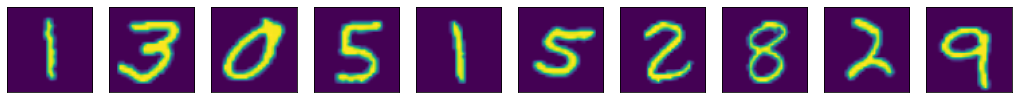

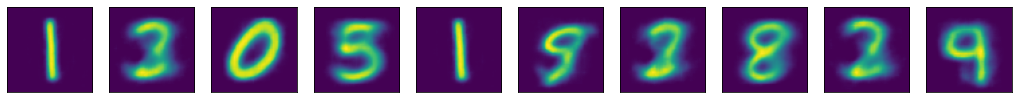

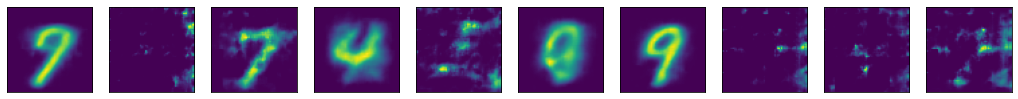

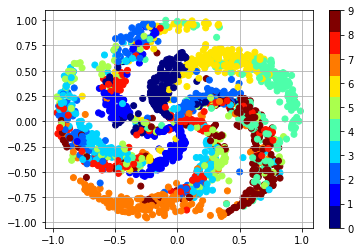

In [14]:
import matplotlib.pyplot as plt
display.clear_output()

batch = next(iter(test_loader))
data = preprocess(batch)

model = model_list[0]
model.eval()
with torch.no_grad():
    data = model(data, M=1024, temperature=1)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = torch.randn(10, hp.z_dim).to(device)
    y = model.sample(z)
    plot(y)

import matplotlib.pyplot as plt
_z = data['z'].data.cpu().numpy()
plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
plt.grid()
plt.colorbar()
plt.show()